# 알고리즘 체인과 파이프라인(Algorithm Chain and Pipeline)
* 3장에서 cancer 데이터셋을 MinMaxScaler로 전처리를 해서 커널 SVM의 성능을 크게 향상시켰었습니다.다음은 데이터를 분할하고 최솟값, 최댓값을 찾아 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드입니다.(improve performance of SVM with preprocessing by MinMaxScaler function)

In [4]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터의 스케일을 조정합니다. 
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다.
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


## 데이터 전처리와 매개변수 선택
* GridSearchCV를 사용해서 더 좋은 SVC 매개변수를 찾으려고 합니다. 어떻게 해야 할까요?

In [6]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요!!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


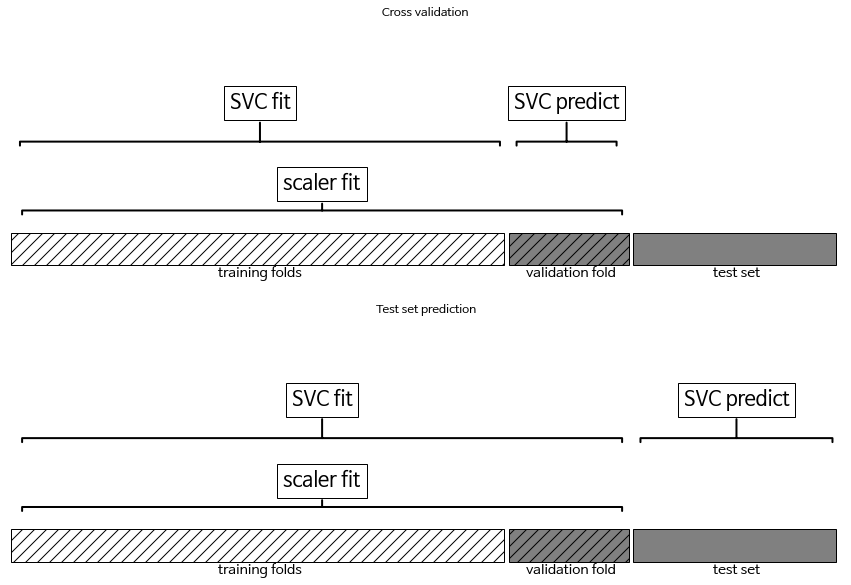

In [7]:
import mglearn
mglearn.plots.plot_improper_processing()

[교차 검증 반복 밖에서 전처리가 될 때 데이터 사용 형태(Data using form when preprocessing outside cross-validation iterations)]

## 파이프라인 구축하기(Building Pipelines)
* MinMaxScaler로 데이터의 스케일을 조정하고 SVM 모델을 훈련시키는 워크플로(workflow)를 Pipeline을 사용해 어떻게 표현하는지 알아보겠습니다(여기서는 그리드 서치는 사용하지 않겠습니다), 먼저 각 단계를 리스트로 전달하여 파이프라인 객체를 만듭니다. 각 단계는 추정기의 객체와 임의의 이름(아무 문자열이나 가능합니다)으로 구성된 튜플(tuple)입니다.

In [10]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

* 여기에서는 두 개의 단계를 만들었습니다. 첫 번째 단계는 "scaler"란 이름으로 MinMaxScaler의 객체입니다. 두 번째는 "svm"이란 이름으로 SVC의 객체입니다. 이제 scikit-learn의 다른 예측 모델처럼 파이프라인에서 fit 메서드를 호출합니다.

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [13]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


## 그리드 서치에 파이프라인 적용하기
* 그리드 서치에 파이프라인을 적용하는 방식 역시 다른 추정기를 사용할 때와 같습니다. 탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 GridSearchCV의 객체를 만듭니다.
* 그런데 매개변수 그리드를 만들 때 조금 달라지는 것이 있습니다. 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 합니다. C와 gamma 매개변수는 두 번째 단계인 SVC의 매개변수 입니다.
* 앞에서 이 단계의 이름을 "svm"이라고 지정했습니다. 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 "__"\(밑줄 문자 2개)로 연결해 만듭니다. 그래서 SVC의 매개변수 C를 그리드 서치로 탐색하려면 매개변수 그리드 딕셔너리의 키를 "svm__C"로 해야 하고 gamma에 대해서도 동일합니다.

In [14]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1 ,10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1 ,10, 100]}

* 이 매개변수 그리드로 GridSearchCV를 보통 때처럼 사용할 수 있습니다.

In [16]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'svm__C': 1, 'svm__gamma': 1}


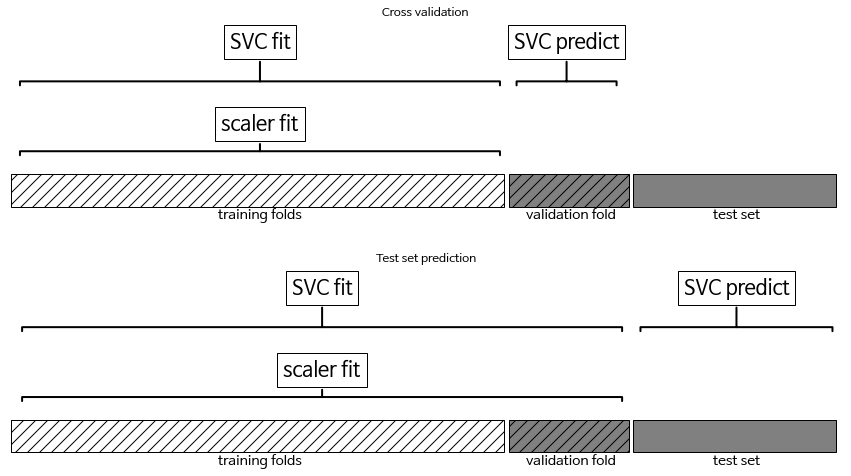

In [17]:
import mglearn
mglearn.plots.plot_proper_processing()

[교차 검증 반복 안에서 전처리가 될 때 데이터 사용 형태(Data using form when preprocessing within cross-validation iterations)]

## 파이프라인 인터페이스

In [8]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다.
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다.
    self.steps[-1][1].fit(X_transformed, y)
    return self

* Pipeline을 사용해서 예측할 때는, 비슷한 방식으로 마지막 단계 이전까지 transform 메서드를 호출한 다음, 마지막 단계에서 predict를 호출합니다.

In [9]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다.
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다.
    return self.steps[-1][1].predict(X_transformed)

### make_pipeline을 사용한 파이프라인 생성
* 파이프라인을 만드는 게 좀 번거롭기도 하고 각 단계에 특별히 이름을 부여하지 않아도 될 경우가 많습니다. make_pipeline 함수는 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프라인을 만들어줍니다. make_pipeline 함수 사용법은 다음과 같습니다.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

* 파이프라인 객체 pipe_long과 pipe_short이 정확히 똑같은 작업을 수행하지만, pipe_short은 단계의 이름을 자동으로 만듭니다. steps 속성에 각 단계의 이름이 있습니다.

In [11]:
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


* 단계 이름은 minmaxscaler와 svc입니다. 일반적으로 단계의 이름은 파이썬 클래스 이름의 소문자 버전입니다. 같은 파이썬 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 추가로 붙습니다.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### 단계 속성에 접근하기(Access Step Properties)
* 종종 파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때가 있습니다. 예를 들면 선형 모델의 계수나 PCA에서 추출한 주성분입니다. 단계 이름을 키로 가진 딕셔너리인 named_steps 속성을 사용하면 파이프라인의 각 단계에 쉽게 접근할 수 있습니다.

In [5]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# cacner 데이터셋에 앞서 만든 파이프라인을 적용합니다.
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다.
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


### 그리드 서치 안의 파이프라인 속성에 접근하기(Access Pipeline Properties in Grid Search)
* 이 장의 서두에 언급했듯이 파이프라인을 사용하는 주된 목적은 그리드 서치 때문입니다. 그래서 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많습니다. 스케일 조정을 위한 StandardScaler와 LogisticRegression 분류기로 Pipeline을 만들어 cancer 데이터셋에 그리드 서치를 적용하겠습니다. 먼저 make_pipeline 함수로 파이프라인을 만듭니다.

In [6]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [7]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

C:\Users\wnstj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wnstj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [ ]:
print("최상의 모델:\n", ㅎ걍.ㅠ)